In [434]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder


from sklearn.model_selection import GridSearchCV, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [435]:
pd.set_option("display.max_columns" , None)
pd.set_option("display.max_rows" , 50)
plt.style.use('ggplot')

train_og = pd.read_csv('train.csv' )
test_og = pd.read_csv('test.csv' )

In [436]:
train_og['Cabin'] = train_og['Cabin'].fillna('None')
train_og['Age'] = train_og['Age'].fillna(train_og['Age'].median())
train_og['Embarked'] = train_og['Embarked'].fillna('S')


test_og['Cabin'] = test_og['Cabin'].fillna('None')
test_og['Age'] = test_og['Age'].fillna(train_og['Age'].median())
test_og['Fare'] = test_og['Fare'].fillna(test_og['Fare'].median())


In [437]:
train_og = train_og.drop(['Name' , 'PassengerId'] , axis=1)
test_og = test_og.drop(['Name' , 'PassengerId'] , axis=1)

In [438]:
train_og['Ticket'] = train_og['Ticket'].str[:2]
train_og['Sex'] = train_og['Sex'].replace({'male': 1, 'female': 0})
train_og['Cabin'] = train_og['Cabin'].str[:1]
# train_og['FamilyMemberEmbarked'] = train_og.apply(lambda row: 1 if (row['Parch'] > 0) or (row['SibSp'] > 0) else 0, axis=1)
# train_og = train_og.drop(['Parch' , 'SibSp'] , axis = 1)
train_og['Parch'] = train_og['Parch'].apply(lambda x: 0 if x == 0 else 1)
train_og['SibSp'] = train_og['SibSp'].apply(lambda x: 0 if x == 0 else 1)

test_og['Ticket'] = test_og['Ticket'].str[:2]
test_og['Sex'] = test_og['Sex'].replace({'male': 1, 'female': 0})
test_og['Cabin'] = test_og['Cabin'].str[:1]
# test_og['FamilyMemberEmbarked'] = test_og.apply(lambda row: 1 if (row['Parch'] > 0) or (row['SibSp'] > 0) else 0, axis=1)
# test_og = test_og.drop(['Parch' , 'SibSp'] , axis = 1)
test_og['Parch'] = test_og['Parch'].apply(lambda x: 0 if x == 0 else 1)
test_og['SibSp'] = test_og['SibSp'].apply(lambda x: 0 if x == 0 else 1)

D:\Users\retbu\AppData\Local\Temp\ipykernel_29496\4105183876.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_og['Sex'] = train_og['Sex'].replace({'male': 1, 'female': 0})
D:\Users\retbu\AppData\Local\Temp\ipykernel_29496\4105183876.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_og['Sex'] = test_og['Sex'].replace({'male': 1, 'female': 0})


In [439]:
# Extract the 'Embarked' column
embarked = train_og[['Embarked']]

# Create and fit the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # handle_unknown is important for unseen data later
encoder.fit(embarked)

# Transform the data
encoded_embarked = encoder.transform(embarked)

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_embarked, columns=encoder.get_feature_names_out(['Embarked']))

# Concatenate the encoded columns with the original DataFrame
train_og = pd.concat([train_og, encoded_df], axis=1)
train_og = train_og.drop('Embarked', axis=1) # remove the original column

In [440]:
# Extract the 'Embarked' column
embarked = test_og[['Embarked']]

# Create and fit the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # handle_unknown is important for unseen data later
encoder.fit(embarked)

# Transform the data
encoded_embarked = encoder.transform(embarked)

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_embarked, columns=encoder.get_feature_names_out(['Embarked']))

# Concatenate the encoded columns with the original DataFrame
test_og = pd.concat([test_og, encoded_df], axis=1)
test_og = test_og.drop('Embarked', axis=1) # remove the original column

In [441]:

categorical_cols = ['Ticket' , 'Cabin']

# Initialize the TargetEncoder
encoder = TargetEncoder(cols=categorical_cols)

# Fit and transform the categorical columns directly in merged_df_train
train_og[categorical_cols] = encoder.fit_transform(train_og[categorical_cols], train_og['Survived'])
test_og[categorical_cols] = encoder.transform(test_og[categorical_cols])


In [442]:
train_og.columns 

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [443]:
features_to_consider = ['Pclass', 'Sex',  'Fare', 
                        'Cabin','Ticket', 
                         'Age',
                        'SibSp', 'Parch',  'Embarked_C', 'Embarked_Q', 'Embarked_S'
                        ]

train_og = train_og[features_to_consider + ['Survived']] 
test_og = test_og[features_to_consider]

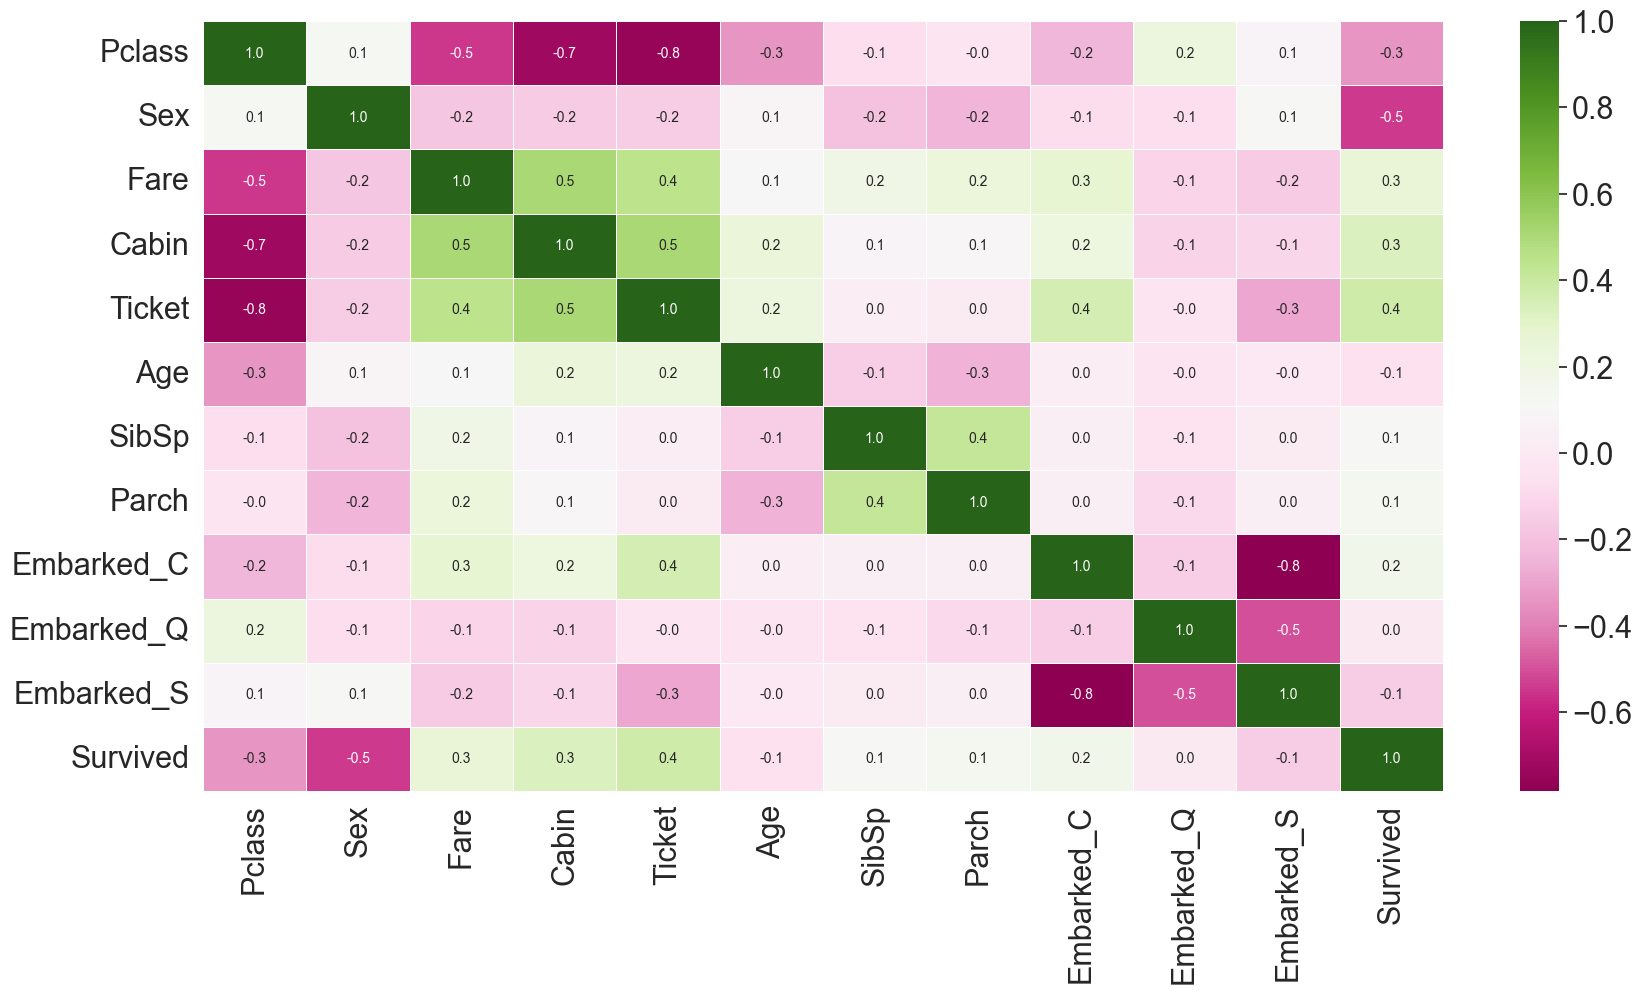

In [444]:
sns.set(font_scale=2)
plt.figure(figsize = (20,10))
ax = sns.heatmap(train_og.corr(), annot=True,annot_kws={"size": 10},fmt='.1f',cmap='PiYG', linewidths=.5)

In [445]:
# Calculate correlations with 'Survived'
correlations = train_og.corr()['Survived']

# Identify features with absolute correlation less than 0.2
low_corr_features = correlations[abs(correlations) < 0.2].index.tolist()

# Remove 'Survived' itself from the list
low_corr_features = [
    feature for feature in low_corr_features if feature != 'Survived'
]

# Print the features
print("Features with less than 0.2 absolute correlation with 'Survived':")
print(low_corr_features)

Features with less than 0.2 absolute correlation with 'Survived':
['Age', 'SibSp', 'Parch', 'Embarked_C', 'Embarked_Q', 'Embarked_S']


In [446]:
# # 1. Replace 0 values with 1
# train_og['Fare'] = train_og['Fare'].replace(0, 1)

# # 2. Apply logarithmic transformation (using natural logarithm here, you can change the base if needed)
# train_og['Fare'] = np.log(train_og['Fare'])

In [447]:
# 1. Prepare the data
X = train_og.drop('Survived', axis=1)  # Features
y = train_og['Survived']  # Target

# 2. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)



In [448]:
# 3. Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [449]:
# 4. Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(#n_neighbors=12
                                                ),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

# 5. Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)  # Predictions on training set
    y_test_pred = model.predict(X_test)    # Predictions on testing set

    # --- Training Set Metrics ---
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
 
    # --- Testing Set Metrics ---
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # --- Confusion Matrix for Testing Set ---
    cm = confusion_matrix(y_test, y_test_pred)

    # Print results
    print(f"----- {name} -----")
    print(f"Training Accuracy:   {train_accuracy:.4f}")
    print(f"Testing Accuracy:    {test_accuracy:.4f}")
    print(30 * '¤')
    print(f"Training F1 Score:   {train_f1:.4f}")
    print(f"Testing F1 Score:    {test_f1:.4f}")
    
    print("Testing Confusion Matrix:")
    print(cm)

    # # Plot confusion matrix for Testing Set
    # plt.figure(figsize=(5, 5))
    # sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
    #             xticklabels=['Not Survived', 'Survived'],
    #             yticklabels=['Not Survived', 'Survived'])
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix (Test Set) - {name}')
    # plt.show()
    

----- Logistic Regression -----
Training Accuracy:   0.8127
Testing Accuracy:    0.7815
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Training F1 Score:   0.7396
Testing F1 Score:    0.7090
Testing Confusion Matrix:
[[184  32]
 [ 46  95]]
----- Support Vector Machine -----
Training Accuracy:   0.8670
Testing Accuracy:    0.8067
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Training F1 Score:   0.8055
Testing F1 Score:    0.7294
Testing Confusion Matrix:
[[195  21]
 [ 48  93]]
----- K-Nearest Neighbors -----
Training Accuracy:   0.8596
Testing Accuracy:    0.7983
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Training F1 Score:   0.8062
Testing F1 Score:    0.7429
Testing Confusion Matrix:
[[181  35]
 [ 37 104]]
----- Decision Tree -----
Training Accuracy:   0.9944
Testing Accuracy:    0.7675
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Training F1 Score:   0.9925
Testing F1 Score:    0.7046
Testing Confusion Matrix:
[[175  41]
 [ 42  99]]
----- Random Forest -----
Training Accuracy:   0.9944
Testing Accuracy:    0.7647
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

In [427]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np  # Import numpy

def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    }

    # Create and train the model
    model = GradientBoostingClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_test_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_test_pred)
    return accuracy

# Initialize Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # You can adjust n_trials

# Get top 10 trials
top_trials = study.best_trials[:10]

# Print results for top trials
print("\nTop 10 Trials:")
for i, trial in enumerate(top_trials):
    print(f"----- Trial {i + 1} -----")
    print(f"  Value (Accuracy): {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Train model with best parameters and get metrics
    best_model = GradientBoostingClassifier(**trial.params, random_state=42)
    best_model.fit(X_train, y_train)
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    cm = confusion_matrix(y_test, y_test_pred)

    print(f"  Training Accuracy:   {train_accuracy:.4f}")
    print(f"  Testing Accuracy:    {test_accuracy:.4f}")
    print(30 * '¤')
    print(f"  Training F1 Score:   {train_f1:.4f}")
    print(f"  Testing F1 Score:    {test_f1:.4f}")
    print("  Testing Confusion Matrix:")
    print(cm)
    print("-" * 30)

[I 2024-12-08 20:03:49,384] A new study created in memory with name: no-name-891d4669-5b03-45de-a9c4-078b4e001c4a
[I 2024-12-08 20:03:49,843] Trial 0 finished with value: 0.803921568627451 and parameters: {'n_estimators': 488, 'learning_rate': 0.012638106038254802, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.803921568627451.
[I 2024-12-08 20:03:51,004] Trial 1 finished with value: 0.8095238095238095 and parameters: {'n_estimators': 658, 'learning_rate': 0.002282721102037197, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8095238095238095.
[I 2024-12-08 20:03:51,151] Trial 2 finished with value: 0.8207282913165266 and parameters: {'n_estimators': 182, 'learning_rate': 0.020344852835586343, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8207282913165266.
[I 2024-12-08 20:03:52,028] Trial 3 finished with value: 0.7619047619047619 and parameters: 


Top 10 Trials:
----- Trial 1 -----
  Value (Accuracy): 0.8263
  Params: 
    n_estimators: 316
    learning_rate: 0.00888467809252437
    max_depth: 3
    min_samples_split: 9
    min_samples_leaf: 2
  Training Accuracy:   0.8839
  Testing Accuracy:    0.8263
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
  Training F1 Score:   0.8324
  Testing F1 Score:    0.7615
  Testing Confusion Matrix:
[[196  20]
 [ 42  99]]
------------------------------


In [ ]:
Chosen_model =  GradientBoostingClassifier(    n_estimators= 316,learning_rate= 0.00889467809252437, max_depth= 3, min_samples_split= 9,min_samples_leaf= 2) 

Chosen_model.fit(X_train, y_train)

# Make predictions
y_train_pred = Chosen_model.predict(X_train)  # Predictions on training set
y_test_pred = Chosen_model.predict(X_test)    # Predictions on testing set

# --- Training Set Metrics ---
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# --- Testing Set Metrics ---
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# --- Confusion Matrix for Testing Set ---
cm = confusion_matrix(y_test, y_test_pred)

# Print results
print(f"----- {name} -----")
print(f"Training Accuracy:   {train_accuracy:.4f}")
print(f"Testing Accuracy:    {test_accuracy:.4f}")
print(30 * '¤')
print(f"Training F1 Score:   {train_f1:.4f}")
print(f"Testing F1 Score:    {test_f1:.4f}")

print("Testing Confusion Matrix:")
print(cm)

----- Gradient Boosting -----
Training Accuracy:   0.8839
Testing Accuracy:    0.8263
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Training F1 Score:   0.8324
Testing F1 Score:    0.7615
Testing Confusion Matrix:
[[196  20]
 [ 42  99]]


In [391]:
Chosen_model =  SVC(C= 0.1, class_weight= None,  gamma =  'scale', kernel =  'rbf') 

Chosen_model.fit(X_train, y_train)

# Make predictions
y_train_pred = Chosen_model.predict(X_train)  # Predictions on training set
y_test_pred = Chosen_model.predict(X_test)    # Predictions on testing set

# --- Training Set Metrics ---
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# --- Testing Set Metrics ---
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# --- Confusion Matrix for Testing Set ---
cm = confusion_matrix(y_test, y_test_pred)

# Print results
print(f"----- {name} -----")
print(f"Training Accuracy:   {train_accuracy:.4f}")
print(f"Testing Accuracy:    {test_accuracy:.4f}")
print(30 * '¤')
print(f"Training F1 Score:   {train_f1:.4f}")
print(f"Testing F1 Score:    {test_f1:.4f}")

print("Testing Confusion Matrix:")
print(cm) 

----- Gradient Boosting -----
Training Accuracy:   0.8408
Testing Accuracy:    0.8039
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Training F1 Score:   0.7684
Testing F1 Score:    0.7348
Testing Confusion Matrix:
[[190  26]
 [ 44  97]]


In [410]:
# # 4. Define models
# models = {
#     "Logistic Regression": LogisticRegression(),
#     "Support Vector Machine": SVC(),
#     "K-Nearest Neighbors": KNeighborsClassifier(#n_neighbors=12
#                                                 ),
#     "Decision Tree": DecisionTreeClassifier(),
#     "Random Forest": RandomForestClassifier(),
#     "Gradient Boosting": GradientBoostingClassifier()
# }

Chosen_model =  RandomForestClassifier()

Chosen_model.fit(X_train, y_train)

# Make predictions
y_train_pred = Chosen_model.predict(X_train)  # Predictions on training set
y_test_pred = Chosen_model.predict(X_test)    # Predictions on testing set

# --- Training Set Metrics ---
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# --- Testing Set Metrics ---
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# --- Confusion Matrix for Testing Set ---
cm = confusion_matrix(y_test, y_test_pred)

# Print results
print(f"----- {name} -----")
print(f"Training Accuracy:   {train_accuracy:.4f}")
print(f"Testing Accuracy:    {test_accuracy:.4f}")
print(30 * '¤')
print(f"Training F1 Score:   {train_f1:.4f}")
print(f"Testing F1 Score:    {test_f1:.4f}")

print("Testing Confusion Matrix:")
print(cm) 

----- Gradient Boosting -----
Training Accuracy:   0.9944
Testing Accuracy:    0.7619
¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤
Training F1 Score:   0.9925
Testing F1 Score:    0.6863
Testing Confusion Matrix:
[[179  37]
 [ 48  93]]


In [450]:

scaler = StandardScaler()
X = scaler.fit_transform(X)
test_og = scaler.transform(test_og)

Chosen_model =  GradientBoostingClassifier(    n_estimators= 316,learning_rate= 0.00889467809252437, max_depth= 3, min_samples_split= 9,min_samples_leaf= 2) 
Chosen_model.fit(X, y)

GradientBoostingClassifier(learning_rate=0.00889467809252437,
                           min_samples_leaf=2, min_samples_split=9,
                           n_estimators=316)

In [451]:
y_pred_raw = Chosen_model.predict(test_og)

# 1. Load the sample submission CSV into a Pandas DataFrame
submission_df = pd.read_csv('gender_submission.csv')

# 2. Assuming y_pred_final is your prediction array/list/Series
#    Replace the 'SalePrice' column with your predictions 
submission_df['Survived'] = y_pred_raw

# 3. Save the updated DataFrame back to a CSV file (you can choose a new name)
submission_df.to_csv('gender_submission.csv', index=False)  # index=False to avoid writing row indices